C:\Users\parde\.conda\envs\latest_python\Lib\site-packages\fastai\vision\learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,0.550586,0.231920,0.064208,04:17
1,0.315491,0.180906,0.047814,04:06
2,0.220580,0.200309,0.043716,03:52
3,0.214701,0.172589,0.047814,03:38
4,0.166599,0.182616,0.045082,03:39
5,0.140355,0.190294,0.043716,04:00
6,0.111471,0.136075,0.031421,04:01
7,0.109799,0.114013,0.030055,04:05
8,0.098633,0.126413,0.035519,03:31
9,0.088881,0.111645,0.032787,03:39


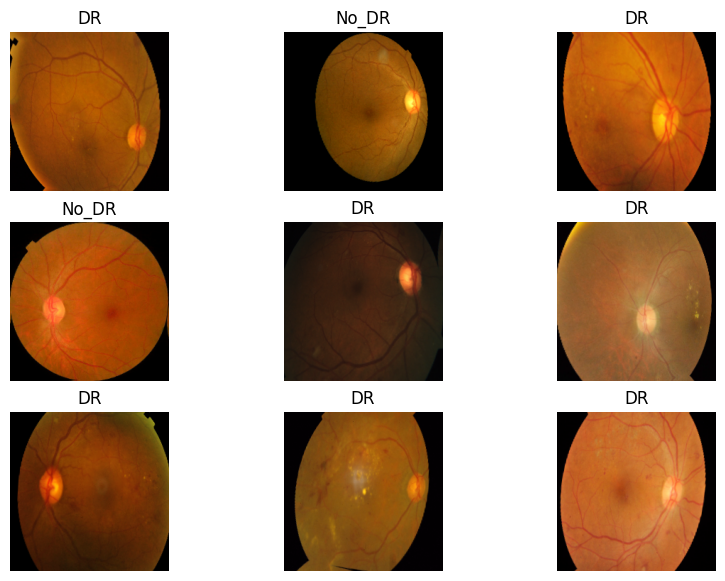

In [1]:
from fastai.vision.all import *
from pathlib import Path
import os

# Set paths for models and plots
model_path = 'models'
plot_path = 'plots'

# Create necessary directories
os.makedirs(model_path, exist_ok=True)
os.makedirs(os.path.join(model_path, plot_path), exist_ok=True)

# Dataset classes and path
classes = ['No_DR', 'DR']
path = Path('Datasets/archive/colored_images')  # Update this to your dataset location

# Check dataset structure
if not path.exists():
    raise FileNotFoundError(f"Dataset path {path} not found. Please check the path.")

# DataBlock for creating the DataLoader
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms()
)

# Create DataLoaders
dls = data_block.dataloaders(path, bs=32, num_workers=4)

# Show a batch of images
dls.show_batch(max_n=9, figsize=(10, 7))

# Create and train the model
learn = cnn_learner(dls, resnet34, metrics=error_rate, model_dir=model_path)

# Fit the model
learn.fit_one_cycle(20)



SuggestedLRs(valley=2.75422871709452e-06)

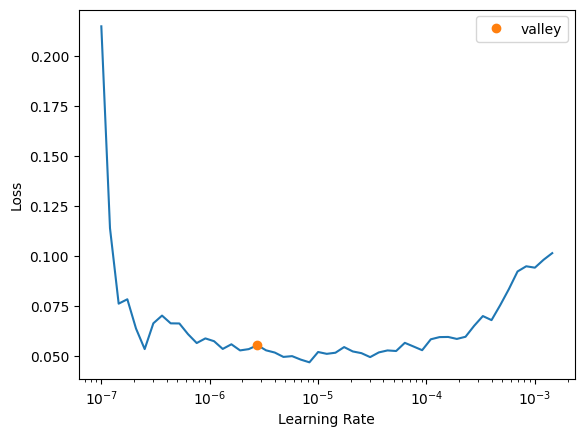

In [3]:
#learn.recorder.plot_losses()

# Save the model
learn.save('colored_stage1')

# Fine-tune the model
learn.unfreeze()
learn.lr_find()
#learn.recorder.plot()


epoch,train_loss,valid_loss,error_rate,time
0,0.049638,0.106359,0.032787,04:48
1,0.048140,0.115759,0.032787,04:40
2,0.045361,0.116706,0.032787,04:38


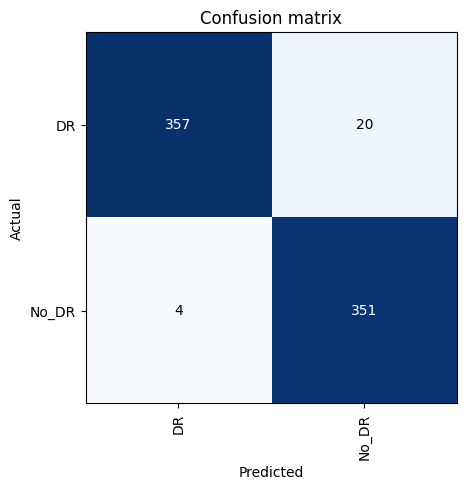

In [4]:
learn.fit_one_cycle(3, lr_max=slice(1e-6, 1e-5))
learn.save('colored_stage2')

# Load the model
learn.load('colored_stage2')

# Interpret results
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Export the trained model
learn.export(os.path.join(model_path, 'colored_export.pkl'))